### Corona trends

This notebook includes scrapping data from CDS, estimating trends, and output the trends in a CSV file.

Data is from [Corona Data Scraper](https://coronadatascraper.com/#home)

the libraries in this file can be all found in [this image](https://hub.docker.com/repository/docker/pipcourbois/tensorflow-notebook-plus)


In [1]:
import numpy as np
import pandas as pd

In [2]:
rawtimeseries = pd.read_csv('https://coronadatascraper.com/timeseries.csv', parse_dates=['date'])

display('Timeseries:')
display(rawtimeseries.head())

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


'Timeseries:'

,name,level,city,county,state,country,population,lat,long,url,...,recovered,active,tested,hospitalized,hospitalized_current,discharged,icu,icu_current,growthFactor,date
0,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-22
1,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-01-23
2,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-01-24
3,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-01-25
4,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-01-26


### USA county-level data

In [3]:
USA = rawtimeseries[(rawtimeseries.country == 'United States') & (rawtimeseries.level == 'county')]

In [4]:
len(USA)

321004

In [5]:
USA.dtypes

name                            object
level                           object
city                            object
county                          object
state                           object
country                         object
population                     float64
lat                            float64
long                           float64
url                             object
aggregate                       object
tz                              object
cases                          float64
deaths                         float64
recovered                      float64
active                         float64
tested                         float64
hospitalized                   float64
hospitalized_current           float64
discharged                     float64
icu                            float64
icu_current                    float64
growthFactor                   float64
date                    datetime64[ns]
dtype: object

#### Don't need all these fields

In [7]:
f=USA[['date','state','county','cases','deaths','hospitalized','tested','population']]

In [8]:
f.set_index(['state','county','date']).head()

cases  deaths  hospitalized  tested  \
state  county        date                                              
Nevada Washoe County 2020-03-05    1.0     NaN           NaN     NaN   
                     2020-03-06    1.0     NaN           NaN     NaN   
                     2020-03-07    1.0     NaN           NaN     NaN   
                     2020-03-08    2.0     NaN           NaN     NaN   
                     2020-03-09    2.0     NaN           NaN     NaN   

                                 population  
state  county        date                    
Nevada Washoe County 2020-03-05    471519.0  
                     2020-03-06    471519.0  
                     2020-03-07    471519.0  
                     2020-03-08    471519.0  
                     2020-03-09    471519.0

### Pull FIPS codes

In [9]:
geo_codes = pd.read_excel('https://www2.census.gov/programs-surveys/popest/geographies/2017/all-geocodes-v2017.xlsx'
                             , skiprows = 5
                             ,header=None
                             ,converters={0:str,1:str,2:str,3:str,4:str,5:str,6:str}
                            )

geo_codes.columns = ['level','statefips','countyfips','drop1','drop2','drop3','county']

In [10]:
geo_codes.dtypes

level         object
statefips     object
countyfips    object
drop1         object
drop2         object
drop3         object
county        object
dtype: object

In [11]:
county_codes = geo_codes[geo_codes['level'] == '050'].drop(columns=['level','drop1','drop2','drop3'])
state_codes = geo_codes[geo_codes['level'] == '040'].drop(columns=['level','countyfips','drop1','drop2','drop3']).rename(columns = {'county':'state'})

In [12]:
county_codes = pd.merge(county_codes,state_codes,how='inner',on='statefips')

In [13]:
county_codes['geo_id'] = county_codes["statefips"] + county_codes["countyfips"]
county_codes.drop(columns = ['statefips','countyfips'],inplace=True)

### merge codes with corona data

In [14]:
f = pd.merge(f, county_codes,how='inner', on=['state','county'])

In [15]:
f.head()

,date,state,county,cases,deaths,hospitalized,tested,population,geo_id
0,2020-03-05,Nevada,Washoe County,1.0,NaN,NaN,NaN,471519.0,32031
1,2020-03-06,Nevada,Washoe County,1.0,NaN,NaN,NaN,471519.0,32031
2,2020-03-07,Nevada,Washoe County,1.0,NaN,NaN,NaN,471519.0,32031
3,2020-03-08,Nevada,Washoe County,2.0,NaN,NaN,NaN,471519.0,32031
4,2020-03-09,Nevada,Washoe County,2.0,NaN,NaN,NaN,471519.0,32031


In [16]:
# there are several wyoming counties
f[(f.state=='New York') & (f.county=='Wyoming County')].head()

,date,state,county,cases,deaths,hospitalized,tested,population,geo_id
201998,2020-03-17,New York,Wyoming County,1.0,NaN,NaN,NaN,39859.0,36121
201999,2020-03-18,New York,Wyoming County,1.0,NaN,NaN,NaN,39859.0,36121
202000,2020-03-19,New York,Wyoming County,2.0,NaN,NaN,NaN,39859.0,36121
202001,2020-03-20,New York,Wyoming County,2.0,NaN,NaN,NaN,39859.0,36121
202002,2020-03-21,New York,Wyoming County,2.0,NaN,NaN,NaN,39859.0,36121


### Data Cleaning

All the data are cumulative since beginning of recording. So we will have to do first-differencing to get the actual number of deaths per day.

The daily cumulative numbers have some inaccuracies: 
1. Have missing data at the beginning and center of timeseries. At the beginning of timeseries the NAs are zero (have not begun recording yet), in the center of a timeseries they cannot be zero.  
1. Have some cumulative numbers that drop from one day to the next.

We have to do the following
1. Roll up to weekly  
1. Clean up NAs 
1. Clean up drops in cumulative numbers

Probably easiest to roll up to the weekly numbers first (not really a rollup, simply take the value for every Sunday since all the numbers are cumulative). This will aleviate some of the other issues. 

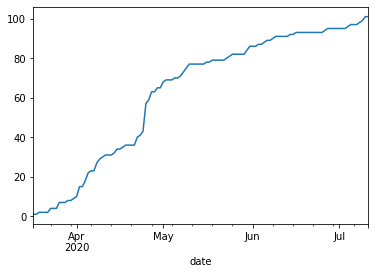

In [17]:
# this is stupid but need date index to get a good plot but I don't want to set index on f permanently because it is annoying later
f[(f.state=='New York') & (f.county=='Wyoming County')].set_index(['date']).loc[:,'cases'].plot()

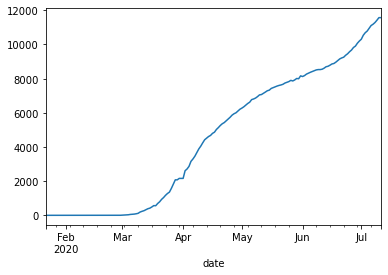

In [18]:
f[(f.state=='Washington') & (f.county=='King County')].set_index(['date']).loc[:,'cases'].plot()

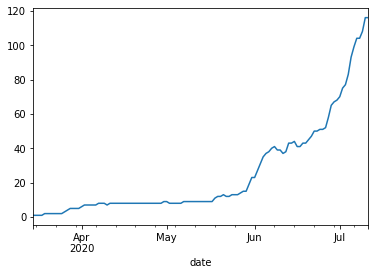

In [19]:
f[(f.state=='North Carolina') & (f.county=='Watauga County')].set_index(['date']).loc[:,'cases'].plot()

#### Missing values 

There are two types of missing values that I want to treat differently: 
1. Missing values at the beginning of a time series 
2. Missing values within a time series

Wyoming County is a good example of both of these.

I will transform these as follows:
1. fill in initial NAs with zero 
1. fill in with the most recent cumulative count (presumably the day before)

Because of the way the fillna code works, we are going to do these in the opposite order (start with step \#2).

In [20]:
# this is step 2, fill with the prior day (or most recent day without NA)
# inital NAs will still be NA
# note: this is not going to backfill to all counties having same start date
f = f.groupby('county',as_index=False).fillna(method='ffill')

In [21]:
# this is step #1 fill remainder of NAs with zero (will always be at beginning of timeseries)
f.fillna(0.0,inplace=True)

In [22]:
f[(f.state=='New York') & (f.county=='Wyoming County')]

,date,state,county,cases,deaths,hospitalized,tested,population,geo_id
201998,2020-03-17,New York,Wyoming County,1.0,0.0,0.0,0.0,39859.0,36121
201999,2020-03-18,New York,Wyoming County,1.0,0.0,0.0,0.0,39859.0,36121
202000,2020-03-19,New York,Wyoming County,2.0,0.0,0.0,0.0,39859.0,36121
202001,2020-03-20,New York,Wyoming County,2.0,0.0,0.0,0.0,39859.0,36121
202002,2020-03-21,New York,Wyoming County,2.0,0.0,0.0,0.0,39859.0,36121
...,...,...,...,...,...,...,...,...,...
202110,2020-07-07,New York,Wyoming County,97.0,3.0,0.0,0.0,39859.0,36121
202111,2020-07-08,New York,Wyoming County,98.0,3.0,0.0,0.0,39859.0,36121
202112,2020-07-09,New York,Wyoming County,99.0,3.0,0.0,0.0,39859.0,36121
202113,2020-07-10,New York,Wyoming County,101.0,3.0,0.0,0.0,39859.0,36121


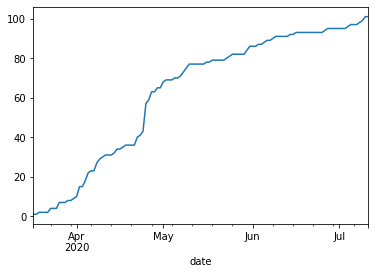

In [23]:
f[(f.state=='New York') & (f.county=='Wyoming County')].set_index(['date']).loc[:,'cases'].plot()

#### Filter to Saturdays

Create a filter for all the Saturdays. Cumulative data through the end of Saturdays.

In [24]:
# sundays = pd.date_range('2019-12-29', '2021-01-31', freq='W-SUN')
saturdays = pd.date_range('2019-12-28', '2021-01-30', freq='W-SAT')

In [25]:
f = f[f.date.isin(saturdays)]

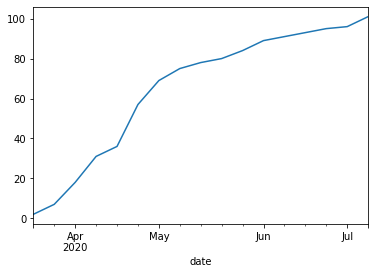

In [26]:
f[(f.state=='New York') & (f.county=='Wyoming County')].set_index(['date']).loc[:,'cases'].plot()

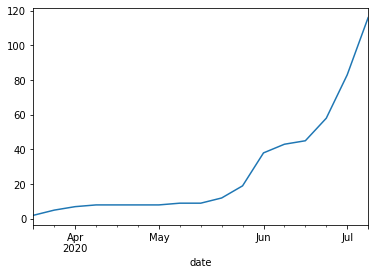

In [27]:
f[(f.state=='North Carolina') & (f.county=='Watauga County')].set_index(['date']).loc[:,'cases'].plot()

## Calculate "new" metrics  

Since all of the metrics are cumulative we need to calculate the "weekly-new" metrics.

In [28]:
f.dtypes

date            datetime64[ns]
state                   object
county                  object
cases                  float64
deaths                 float64
hospitalized           float64
tested                 float64
population             float64
geo_id                  object
dtype: object

In [30]:
# this should be run as a function and a loop but I am lazy
f['prev_value'] = f.groupby(['state','county'])['cases'].shift(1)
f['new_cases'] = f['cases']-f['prev_value']

f['prev_value'] = f.groupby(['state','county'])['deaths'].shift(1)
f['new_deaths'] = f['deaths']-f['prev_value']

f['prev_value'] = f.groupby(['state','county'])['hospitalized'].shift(1)
f['new_hospitalized'] = f['hospitalized']-f['prev_value']

f['prev_value'] = f.groupby(['state','county'])['tested'].shift(1)
f['new_tested'] = f['tested']-f['prev_value']

f.drop(columns=['prev_value'],inplace=True)

#once again fill in the NaNs
f.fillna(0.0,inplace=True)

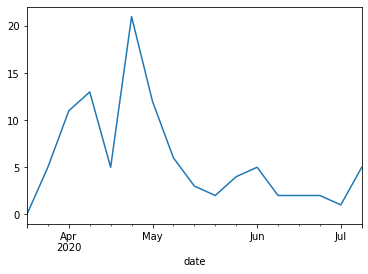

In [32]:
f[(f.state=='New York') & (f.county=='Wyoming County')].set_index(['date']).loc[:,'new_cases'].plot()

In [31]:
f.head()

,date,state,county,cases,deaths,hospitalized,tested,population,geo_id,new_cases,new_deaths,new_hospitalized,new_tested
2,2020-03-07,Nevada,Washoe County,1.0,0.0,0.0,0.0,471519.0,32031,0.0,0.0,0.0,0.0
9,2020-03-14,Nevada,Washoe County,4.0,0.0,0.0,0.0,471519.0,32031,3.0,0.0,0.0,0.0
16,2020-03-21,Nevada,Washoe County,25.0,0.0,0.0,0.0,471519.0,32031,21.0,0.0,0.0,0.0
23,2020-03-28,Nevada,Washoe County,93.0,0.0,0.0,0.0,471519.0,32031,68.0,0.0,0.0,0.0
30,2020-04-04,Nevada,Washoe County,245.0,4.0,0.0,0.0,471519.0,32031,152.0,4.0,0.0,0.0


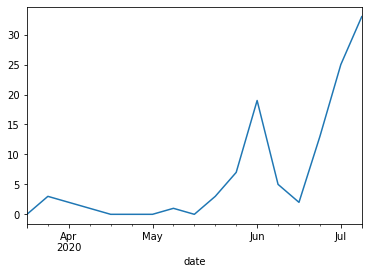

In [33]:
f[(f.state=='North Carolina') & (f.county=='Watauga County')].set_index(['date']).loc[:,'new_cases'].plot()

## Trends

1. Week over week 
1. Week over 4 week lag
2. Four week linear trend
3. Four week incident rate ratios <- need better name here

In [34]:
trend_vars = ['new_cases','new_deaths','new_hospitalized','new_tested']

In [36]:
def wow(df,column,new_column,lag):
    df = df.copy()
    new_column_pct = new_column + '_pct'
    df['prev_value'] = df.groupby(['geo_id'])[column].shift(lag)
    df[new_column] = df[column]-df['prev_value']
    df.loc[np.isnan(df[new_column]), new_column] = 0.0
    df[new_column_pct] = df[new_column]/df['prev_value']
    # fix missings and 0/0
    df.loc[np.isnan(df[new_column_pct]), new_column_pct] = 0.0
    # fix /0
    df.loc[~np.isfinite(df[new_column_pct]), new_column_pct] = 1.0
    df.drop(columns=['prev_value'],inplace=True)
    return df

In [37]:
ft=f.copy().set_index(['geo_id','date'])

In [38]:
for var in trend_vars:
    new_var = var + '_wow'
    print('{}'.format(new_var))
    ft = wow(ft,var,new_var,1)

new_cases_wow
new_deaths_wow
new_hospitalized_wow
new_tested_wow


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


In [ ]:
for var in trend_vars:
    new_var = var + '_wo2w'
    print('{}'.format(new_var))
    ft = wow(ft,var,new_var,2)

In [39]:
ft.head()

state         county  cases  deaths  hospitalized  tested  \
geo_id date                                                                     
32031  2020-03-07  Nevada  Washoe County    1.0     0.0           0.0     0.0   
       2020-03-14  Nevada  Washoe County    4.0     0.0           0.0     0.0   
       2020-03-21  Nevada  Washoe County   25.0     0.0           0.0     0.0   
       2020-03-28  Nevada  Washoe County   93.0     0.0           0.0     0.0   
       2020-04-04  Nevada  Washoe County  245.0     4.0           0.0     0.0   

                   population  new_cases  new_deaths  new_hospitalized  \
geo_id date                                                              
32031  2020-03-07    471519.0        0.0         0.0               0.0   
       2020-03-14    471519.0        3.0         0.0               0.0   
       2020-03-21    471519.0       21.0         0.0               0.0   
       2020-03-28    471519.0       68.0         0.0               0.0   
       2020-04-04    471519.0      152.0         4.0               0.0   

                   new_tested  new_cases_wow  new_cases_wow_pct  \
geo_id date                                                       
32031  2020-03-07         0.0            0.0           0.000000   
       2020-03-14         0.0            3.0           1.000000   
       2020-03-21         0.0           18.0           6.000000   
       2020-03-28         0.0           47.0           2.238095   
       2020-04-04         0.0           84.0           1.235294   

                   new_deaths_wow  new_deaths_wow_pct  new_hospitalized_wow  \
geo_id date                                                                   
32031  2020-03-07             0.0                 0.0                   0.0   
       2020-03-14             0.0                 0.0                   0.0   
       2020-03-21             0.0                 0.0                   0.0   
       2020-03-28             0.0                 0.0                   0.0   
       2020-04-04             4.0                 1.0                   0.0   

                   new_hospitalized_wow_pct  new_tested_wow  \
geo_id date                                                   
32031  2020-03-07                       0.0             0.0   
       2020-03-14                       0.0             0.0   
       2020-03-21                       0.0             0.0   
       2020-03-28                       0.0             0.0   
       2020-04-04                       0.0             0.0   

                   new_tested_wow_pct  
geo_id date                            
32031  2020-03-07                 0.0  
       2020-03-14                 0.0  
       2020-03-21                 0.0  
       2020-03-28                 0.0  
       2020-04-04                 0.0

In [ ]:
ft['new_deaths_wo2w'].plot.hist()

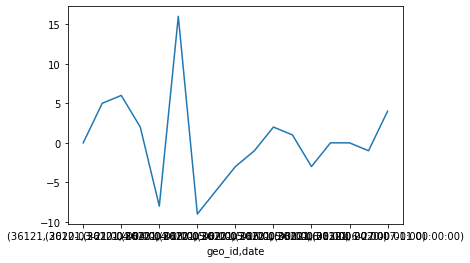

In [40]:
ft[(ft.state=='New York') & (ft.county=='Wyoming County')].loc[:,'new_cases_wow'].plot()

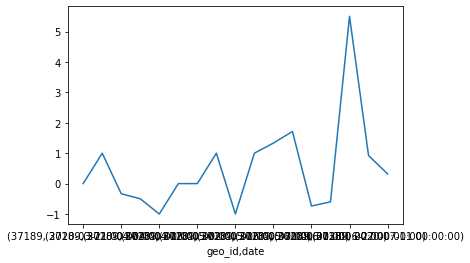

In [41]:
ft[(ft.state=='North Carolina') & (ft.county=='Watauga County')].loc[:,'new_cases_wow_pct'].plot()

### Average weekly trends

In [43]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def rolling_trend_linear(y):
    # this will be a slope per week, this X assumes all weeks are included
    x=np.arange(0,len(y),1).reshape(-1,1)
    regressor = LinearRegression()
    try:
        regressor.fit(x,y) 
    except:
        return 
    
    return regressor.coef_


# incomplete
def rolling_trend_loglinear(y):
    # this will be a slope per week, this X assumes all weeks are included
    x=np.arange(0,len(y),1).reshape(-1,1)
    regressor = LinearRegression()
    try:
        regressor.fit(x,y) 
    except:
        return 
    
    return regressor.coef_

In [49]:
ft2 = ft.copy()

In [44]:
ft2.dtypes

state                        object
county                       object
cases                       float64
deaths                      float64
hospitalized                float64
tested                      float64
population                  float64
new_cases                   float64
new_deaths                  float64
new_hospitalized            float64
new_tested                  float64
new_cases_wow               float64
new_cases_wow_pct           float64
new_deaths_wow              float64
new_deaths_wow_pct          float64
new_hospitalized_wow        float64
new_hospitalized_wow_pct    float64
new_tested_wow              float64
new_tested_wow_pct          float64
dtype: object

In [45]:
ft2.reset_index(level=1)['date'].value_counts()

2020-07-11    3017
2020-07-04    3015
2020-06-27    3002
2020-06-20    2987
2020-06-13    2982
2020-06-06    2966
2020-05-23    2912
2020-05-16    2904
2020-05-30    2895
2020-05-09    2891
2020-05-02    2854
2020-04-25    2816
2020-04-18    2722
2020-04-11    2634
2020-04-04    2425
2020-03-28    1904
2020-03-21    1029
2020-03-14     370
2020-03-07      96
2020-02-29      23
2020-02-22      16
2020-02-15      13
2020-02-08      11
2020-02-01       8
2020-01-25       4
Name: date, dtype: int64

In [46]:
def apply_linear_trend(df,column,new_column,lag):
    df = df.copy()
    temp = df.rolling(lag)[column].apply(rolling_trend_linear)
    temp = temp.to_frame().rename(columns={column : new_column})    
    df = pd.merge(df,temp,how='left', on=['geo_id','date'])
    return df

In [50]:
for var in trend_vars:
    new_var = var + '_4w_linear'
    ft2 = apply_linear_trend(ft2,var,new_var,4)
    print('{}'.format(new_var))

new_cases_4w_linear
new_deaths_4w_linear
new_hospitalized_4w_linear
new_tested_4w_linear


In [48]:
ft2.head(10)

state           county   cases  deaths  hospitalized  \
geo_id date                                                                  
32031  2020-03-07    Nevada    Washoe County     1.0     0.0           0.0   
       2020-03-14    Nevada    Washoe County     4.0     0.0           0.0   
       2020-03-21    Nevada    Washoe County    25.0     0.0           0.0   
       2020-03-28    Nevada    Washoe County    93.0     0.0           0.0   
       2020-04-04    Nevada    Washoe County   245.0     4.0           0.0   
       2020-04-11    Nevada    Washoe County   415.0    11.0           0.0   
       2020-04-18    Nevada    Washoe County   606.0    16.0           0.0   
       2020-04-25    Nevada    Washoe County   791.0    27.0           0.0   
       2020-05-02    Nevada    Washoe County   949.0    33.0           0.0   
       2020-05-09    Nevada    Washoe County  1077.0    39.0           0.0   
       2020-05-16    Nevada    Washoe County  1202.0    46.0           0.0   
       2020-05-23    Nevada    Washoe County  1361.0    50.0           0.0   
       2020-05-30    Nevada    Washoe County  1548.0    60.0           0.0   
       2020-06-06    Nevada    Washoe County  1719.0    65.0           0.0   
       2020-06-13    Nevada    Washoe County  1955.0    70.0           0.0   
       2020-06-20    Nevada    Washoe County  2179.0    73.0           0.0   
       2020-06-27    Nevada    Washoe County  2573.0    74.0           0.0   
       2020-07-04    Nevada    Washoe County  3165.0    79.0           0.0   
       2020-07-11    Nevada    Washoe County  3574.0    92.0           0.0   
51001  2020-03-28  Virginia  Accomack County     2.0     0.0           0.0   

                   tested  population  new_cases  new_deaths  \
geo_id date                                                    
32031  2020-03-07     0.0    471519.0        0.0         0.0   
       2020-03-14     0.0    471519.0        3.0         0.0   
       2020-03-21     0.0    471519.0       21.0         0.0   
       2020-03-28     0.0    471519.0       68.0         0.0   
       2020-04-04     0.0    471519.0      152.0         4.0   
       2020-04-11     0.0    471519.0      170.0         7.0   
       2020-04-18     0.0    471519.0      191.0         5.0   
       2020-04-25     0.0    471519.0      185.0        11.0   
       2020-05-02     0.0    471519.0      158.0         6.0   
       2020-05-09     0.0    471519.0      128.0         6.0   
       2020-05-16     0.0    471519.0      125.0         7.0   
       2020-05-23     0.0    471519.0      159.0         4.0   
       2020-05-30     0.0    471519.0      187.0        10.0   
       2020-06-06     0.0    471519.0      171.0         5.0   
       2020-06-13     0.0    471519.0      236.0         5.0   
       2020-06-20     0.0    471519.0      224.0         3.0   
       2020-06-27     0.0    471519.0      394.0         1.0   
       2020-07-04     0.0    471519.0      592.0         5.0   
       2020-07-11     0.0    471519.0      409.0        13.0   
51001  2020-03-28     0.0     32316.0        0.0         0.0   

                   new_hospitalized  ...  new_deaths_wow  new_deaths_wow_pct  \
geo_id date                          ...                                       
32031  2020-03-07               0.0  ...             0.0            0.000000   
       2020-03-14               0.0  ...             0.0            0.000000   
       2020-03-21               0.0  ...             0.0            0.000000   
       2020-03-28               0.0  ...             0.0            0.000000   
       2020-04-04               0.0  ...             4.0            1.000000   
       2020-04-11               0.0  ...             3.0            0.750000   
       2020-04-18               0.0  ...            -2.0           -0.285714   
       2020-04-25               0.0  ...             6.0            1.200000   
       2020-05-02               0.0  ...            -5.0           -0.454545   
       2020-05-0

In [ ]:
ft2.reset_index(level=1)['date'].value_counts()

In [ ]:
ft2[(ft2.state=='North Carolina') & (ft2.county=='Watauga County')].loc[:,'new_cases_4w_trend'].plot()

In [ ]:
ft[(ft.state=='North Carolina') & (ft.county=='Watauga County')].loc[:,'new_cases_wow'].plot()

#### Export the data

In [ ]:
ft3 = ft2.copy()

In [ ]:
ft3.reset_index(level=[0,1], inplace=True)

In [ ]:
ft3.head()

In [ ]:
ft3['date'].value_counts()

In [ ]:
ft2.to_csv('county_covid_health_trends.csv')
ft2[ft2['date'] == '2020-07-04'].to_csv('county_covid_health_trends_7-04.csv')

### Get most recent date

In [ ]:
NY  = f[(f['state'] == 'New York') & (f['date'] == '2020-07-04')].copy()

In [ ]:
NY.head()